# TF Object Detection on Custom Data
In this notebook we will train a TensorFlow Object Detection model with a (large) custom dataset. We will cover the following steps:  
* Install TensorFlow and TF Object Detection API
* Fetch a pre-trained model from the TensorFlow detection model zoo
* Configure the model and run training with the custom dataset
* Make predictions with the trained model

Now, the TensorFlow Object Detection API is not for the faint of heart to get started on, but once a few tweaks are in place, it is mostly smooth sailing.

## Install TF Object Detection API
The [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) is at the time of writing not compatible with TF2 , so we need to install TF1.14 first. This notebook produces quite a lot of local files, and to keep a tidy house any large files not required will be removed (`rm -fr`).

In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
%%capture
HAVE_GPU = True # change according to environment
if HAVE_GPU:
    !pip install --user tensorflow-gpu==1.14 -q
else:
    !pip install --user tensorflow==1.14 -q
# never mind the `ERROR: tensorflow 2.1...` message below

In [3]:
# make sure we the required packages
!pip install --user Cython -q
!pip install --user contextlib2 -q
!pip install --user pillow -q
!pip install --user lxml -q
!pip install --user matplotlib -q

!pip install --user lvis -q

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tensorflow 2.1.0rc0 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 2.1.0rc0 has requirement tensorflow-estimator<2.1.0,>=2.0.0, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
ERROR: tensorflow-probability 0.8.0 has requirement cloudpickle==1.1.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.19.5 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: hyperopt 0.2.2 has requirement networkx==2.2, but you'll have networkx 2.4 which 

We need to install the `protoc` compiler. On windows, you can get [precompiled binaries here](https://github.com/protocolbuffers/protobuf/releases).

In [4]:
!wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip -q
!unzip -o protobuf.zip
!rm protobuf.zip

Archive:  protobuf.zip
   creating: include/
   creating: include/google/
   creating: include/google/protobuf/
  inflating: include/google/protobuf/struct.proto  
  inflating: include/google/protobuf/type.proto  
  inflating: include/google/protobuf/descriptor.proto  
  inflating: include/google/protobuf/api.proto  
  inflating: include/google/protobuf/empty.proto  
   creating: include/google/protobuf/compiler/
  inflating: include/google/protobuf/compiler/plugin.proto  
  inflating: include/google/protobuf/any.proto  
  inflating: include/google/protobuf/field_mask.proto  
  inflating: include/google/protobuf/wrappers.proto  
  inflating: include/google/protobuf/timestamp.proto  
  inflating: include/google/protobuf/duration.proto  
  inflating: include/google/protobuf/source_context.proto  
   creating: bin/
  inflating: bin/protoc              
  inflating: readme.txt              


Time to fetch the Object Detection API.
<div class="alert alert-block alert-info">
<b>Tip:</b> Move up one level to avoid kernel crash when cloning repositories with deep folder structure.
</div>

In [5]:
%cd /kaggle
!rm -fr models
!git clone https://github.com/tensorflow/models.git
!rm -fr models/.git

/kaggle
Cloning into 'models'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 50733 (delta 4), reused 10 (delta 1), pack-reused 50720
Receiving objects: 100% (50733/50733), 568.65 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (34554/34554), done.


Then compile the protocol buffer messages needed by the API.

In [6]:
# compile ProtoBuffers
%cd models/research
!../../working/bin/protoc object_detection/protos/*.proto --python_out=.

/kaggle/models/research


In [7]:
import os

os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONPATH']=os.environ['PYTHONPATH']+':/kaggle/models/research/slim:/kaggle/models/research'
os.environ['PYTHONPATH']

'/kaggle/lib/kagglegym:/kaggle/lib:/kaggle/models/research/slim:/kaggle/models/research'

In [8]:
!pip install tf_slim

     |████████████████████████████████| 358kB 2.8MB/s eta 0:00:01


That's it! We can now test our setup by running `model_builder_test.py`.

In [9]:
# !pwd
# !python object_detection/builders/model_builder_test.py

/kaggle/models/research
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

Yohoo, it works!  
Now, we did not install the Coco API, since we will be using the Pascal VOC evaluation metric. Unfortunately, there are some hardcoded references to the Coco API that needs to be commented out. Alternatively, just install the Coco API.

In [10]:
!pip install --user 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -q

In [10]:
# def disable_coco(file):
#     with open(file,'r') as f:
#         file_str = f.read()
#     file_str=file_str.replace('from object_detection.metrics import coco_evaluation',
#                     '#from object_detection.metrics import coco_evaluation')
#     file_str=file_str.replace('object_detection.metrics import coco_tools',
#                     '#object_detection.metrics import coco_tools')
#     file_str=file_str.replace('\'coco_detection_metrics\':', '#\'coco_detection_metrics\':')
#     file_str=file_str.replace('coco_evaluation.CocoDetectionEvaluator,', '#coco_evaluation.CocoDetectionEvaluator,')
#     file_str=file_str.replace('\'coco_mask_metrics\':','#\'coco_mask_metrics\':')
#     file_str=file_str.replace('coco_evaluation.CocoMaskEvaluator,','#coco_evaluation.CocoMaskEvaluator,')
#     with open(file,'w') as f:
#         f.write(file_str)

# disable_coco('./object_detection/eval_util.py')

## Fetch a model from the zoo
We will start with a pre-trained model from [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Our custom dataset is the [ArTaxOr dataset](https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-dataset), which contains images of invertebrate animals. Thus it makes sense to choose one of the iNaturalist Species-trained model. 

In [11]:
%cd object_detection
!wget -O faster_rcnn_resnet50_fgvc_2018_07_19.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_fgvc_2018_07_19.tar.gz -q
!tar xvzf faster_rcnn_resnet50_fgvc_2018_07_19.tar.gz
!rm faster_rcnn_resnet50_fgvc_2018_07_19.tar.gz
%cd ..

/kaggle/models/research/object_detection
faster_rcnn_resnet50_fgvc_2018_07_19/model.ckpt.meta
faster_rcnn_resnet50_fgvc_2018_07_19/model.ckpt.index
faster_rcnn_resnet50_fgvc_2018_07_19/pipeline.config
faster_rcnn_resnet50_fgvc_2018_07_19/saved_model/
faster_rcnn_resnet50_fgvc_2018_07_19/checkpoint
faster_rcnn_resnet50_fgvc_2018_07_19/
faster_rcnn_resnet50_fgvc_2018_07_19/saved_model/saved_model.pb
faster_rcnn_resnet50_fgvc_2018_07_19/frozen_inference_graph.pb
faster_rcnn_resnet50_fgvc_2018_07_19/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_fgvc_2018_07_19/saved_model/variables/
/kaggle/models/research


<div class="alert alert-block alert-info">
<b>Tip:</b> Remove the <b>checkpoint</b> file, otherwise training will fail while loading graph.
</div>

In [12]:
!rm object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/checkpoint

Furthermore, create a directory for saved models (otherwise an error will occur when training is finished).

In [13]:
%cd object_detection/faster_rcnn_resnet50_fgvc_2018_07_19
!mkdir export
%cd export
!mkdir Servo
%cd ../../..

/kaggle/models/research/object_detection/faster_rcnn_resnet50_fgvc_2018_07_19
/kaggle/models/research/object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/export
/kaggle/models/research


## **Time to create tf-records**

In [14]:
import json
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

with open('/kaggle/input/sudokuimagesannotations/sudoku_annot_2.json', "r") as read_file:
    data = json.load(read_file)
    
path = "/kaggle/input/sudokuscreenshots/sudoku_imgs/"
keys_list = list(data['_via_img_metadata'].keys())
json_list = []
for key in keys_list:
    i= keys_list.index(key)
    val = data['_via_img_metadata'][key]['regions'][0]['shape_attributes']
    key = key[:-6]
    temp_image = cv2.imread(path + str(key))
    value = (key,temp_image.shape[0],temp_image.shape[1],'Sudoku',val['x'],val['y'], val['x'] + val['width'], val['y'] + val['height'])
    json_list.append(value)
    
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
json_df = pd.DataFrame(json_list, columns=column_name)

# json_df.head()

In [15]:
%cd ../../
%cd working/
!mkdir prog_outputs/
%cd prog_outputs

json_df.to_csv('/kaggle/working/prog_outputs/sudoku_labels.csv', index=False)
json_df.head()

/kaggle
/kaggle/working
/kaggle/working/prog_outputs


,filename,width,height,class,xmin,ymin,xmax,ymax
0,Screenshot_2021-01-07-23-19-00-858_com.easybra...,2280,1080,Sudoku,8,306,1059,1369
1,Screenshot_2021-01-07-23-19-21-187_com.easybra...,2280,1080,Sudoku,5,299,1062,1365
2,Screenshot_2021-01-07-23-19-37-128_com.easybra...,2280,1080,Sudoku,19,323,1066,1366
3,Screenshot_2021-01-07-23-19-52-081_com.easybra...,2280,1080,Sudoku,13,306,1076,1373
4,Screenshot_2021-01-07-23-20-03-976_com.easybra...,2280,1080,Sudoku,17,310,1068,1369


In [16]:
!mkdir temp/
%cd temp
!cp -r '/kaggle/input/sudokuscreenshots/sudoku_imgs/' ./

/kaggle/working/prog_outputs/temp


In [17]:
#not rescaling it now, as labelling has already been done

# from PIL import Image
# import os

# def rescale_images(directory, size):
#     for img in os.listdir(directory):
#         im = Image.open(directory+img)
#         im_resized = im.resize(size, Image.ANTIALIAS)
#         im_resized.save(directory+img)

# size = (512,512)
# rescale_images ('/kaggle/working/prog_outputs/temp/sudoku_imgs/', size)

In [18]:
from os import listdir
import random
from os.path import isfile, join
mypath = '/kaggle/working/prog_outputs/temp/sudoku_imgs/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
random.shuffle(onlyfiles)

train_imgs = onlyfiles[:70]
test_imgs = onlyfiles[70:86]
print(len(train_imgs))
print(len(test_imgs))

70
16


In [ ]:
%cd ..
!mkdir train_imgs/
!mkdir test_imgs/

In [21]:
from shutil import copyfile, copy2
directory = '/kaggle/working/prog_outputs/temp/sudoku_imgs/'
for img in os.listdir(directory):
    source = directory + img
    if img in train_imgs:
        copy2(source, 'train_imgs/')
    elif img in test_imgs:
        copy2(source, 'test_imgs/' )

/kaggle/working


In [22]:
train_labels = json_df
test_labels = json_df
for index, row in json_df.iterrows():
    if row['filename'] in train_imgs:
        test_labels = test_labels.drop(index)
    elif row['filename'] in test_imgs:
        train_labels = train_labels.drop(index)

print(len(train_labels))
print(len(test_labels))

test_labels = test_labels.reset_index()
test_labels = test_labels.drop('index', axis = 1)
test_labels.to_csv('test_labels.csv',index=False)

train_labels = train_labels.reset_index()
train_labels = train_labels.drop('index', axis = 1)
train_labels.to_csv('train_labels.csv',index=False)

70
16


after running till here I am in this folder  /kaggle/working/prog_outputs, I should be in Kaggle/

In [23]:
%cd ../../
%cd models/research/

/
[Errno 2] No such file or directory: 'models/research/'
/


In [28]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record
  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

# flags = tf.app.flags
# flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# flags.DEFINE_string('image_dir', '', 'Path to images')
# FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'Sudoku':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(csv_input, output_path,image_dir):
    writer = tf.python_io.TFRecordWriter(output_path)
#     path = os.path.join(image_dir)
    print(path)
    examples = pd.read_csv(csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
#         print(group)
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


# if __name__ == '__main__':
#     tf.app.run()

In [29]:
%cd ../../
%cd working/prog_outputs/
!mkdir tf-records/
%cd ../../

/kaggle
/kaggle/working/prog_outputs
/kaggle


In [30]:
train_output_path = 'working/prog_outputs/tf-records/train.record'
train_csv_input = 'working/prog_outputs/train_labels.csv'
train_image_dir = 'working/prog_outputs/train_imgs/'

test_output_path = 'working/prog_outputs/tf-records/test.record'
test_csv_input = 'working/prog_outputs/test_labels.csv'
test_image_dir = 'working/prog_outputs/test_imgs/'

main(train_csv_input, train_output_path, train_image_dir)
main(test_csv_input, test_output_path, test_image_dir)

/kaggle/input/sudokuscreenshots/sudoku_imgs/
Successfully created the TFRecords: /kaggle/working/prog_outputs/tf-records/train.record
/kaggle/input/sudokuscreenshots/sudoku_imgs/
Successfully created the TFRecords: /kaggle/working/prog_outputs/tf-records/test.record


In [31]:
pwd

'/kaggle'

In [32]:
%cd working/prog_outputs/tf-records
!ls -la
%cd ../../../

/kaggle/working/prog_outputs/tf-records
total 25060
drwxr-xr-x 2 root root     4096 Jan 21 18:55 .
drwxr-xr-x 6 root root     4096 Jan 21 18:55 ..
-rw-r--r-- 1 root root  4655461 Jan 21 18:55 test.record
-rw-r--r-- 1 root root 20994223 Jan 21 18:55 train.record
/kaggle


## Create a label map .pbtxt file

In [33]:
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format


def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text



txt = convert_classes(['Sudoku'])
print(txt)
with open('working/prog_outputs/label_map.pbtxt', 'w') as f:
    f.write(txt)

item {
  name: "Sudoku"
  id: 1
}



### Config file
Then we need to define the model `.config` file. Here we set up paths to the dataset and a few other parameters. Thankfully, TFRecords for the ArTaxOr dataset has been created in [this notebook](https://www.kaggle.com/mistag/tensorflow-tfrecords-demystified) so we can link directly to its output files. We will use a 80-20 split for training and evaluation, and since the dataset is sharded in 50 files, we can simply select 10 of them (arbitrary) to go into the evaluation set. We also need to determine how many images there are in the evaluation set to configure the evaluation stage correctly:

In [34]:
%cd models/research/
# !ls -la

/kaggle/models/research
total 100
drwxr-xr-x 23 root root 4096 Jan 21 18:51 .
drwxr-xr-x  7 root root 4096 Jan 21 18:51 ..
-rw-r--r--  1 root root 7132 Jan 21 18:51 README.md
drwxr-xr-x  2 root root 4096 Jan 21 18:51 a3c_blogpost
drwxr-xr-x  3 root root 4096 Jan 21 18:51 adversarial_text
drwxr-xr-x  3 root root 4096 Jan 21 18:51 attention_ocr
drwxr-xr-x  4 root root 4096 Jan 21 18:51 audioset
drwxr-xr-x  2 root root 4096 Jan 21 18:51 autoaugment
drwxr-xr-x  4 root root 4096 Jan 21 18:51 cognitive_planning
drwxr-xr-x  7 root root 4096 Jan 21 18:51 cvt_text
drwxr-xr-x  3 root root 4096 Jan 21 18:51 deep_speech
drwxr-xr-x  9 root root 4096 Jan 21 18:51 deeplab
drwxr-xr-x  3 root root 4096 Jan 21 18:51 delf
drwxr-xr-x  8 root root 4096 Jan 21 18:51 efficient-hrl
drwxr-xr-x  3 root root 4096 Jan 21 18:51 lfads
drwxr-xr-x 13 root root 4096 Jan 21 18:51 lstm_object_detection
drwxr-xr-x  2 root root 4096 Jan 21 18:51 marco
drwxr-xr-x  2 root root 4096 Jan 21 18:51 nst_blogpost
drwxr-xr-x 29 ro

In [35]:
import tensorflow as tf

#input_pattern='/kaggle/input/tensorflow-tfrecords-demystified/ArTaxOr-????1-of-00050.tfrecord;/kaggle/input/tensorflow-tfrecords-demystified/ArTaxOr-????7-of-00050.tfrecord'
#input_files = tf.io.gfile.glob(input_pattern)
# data_set = tf.data.TFRecordDataset('/kaggle/working/prog_outputs/tf-records/train.record')
# records_n = sum(1 for record in data_set)
records_n = 70 # takes a long time to run this, so cheating here
print("records_n = {}".format(records_n))

records_n = 70


In [36]:
import sys

os.environ['DATA_PATH']='/kaggle/working/prog_outputs/tf-records'       
os.environ['MODEL_PATH']='object_detection/faster_rcnn_resnet50_fgvc_2018_07_19'

In [46]:
%%writefile 'object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/sudoku.config'
model {
  faster_rcnn {
    num_classes: 1 # sudoku has 1 class currently
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet50'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_batch_size: 32
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 50
        max_total_detections: 100
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  num_steps: 4000000
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 20000
            learning_rate: .00002
          }
          schedule {
            step: 50000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/kaggle/models/research/object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/model.ckpt"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  label_map_path: "/kaggle/working/prog_outputs/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/kaggle/working/prog_outputs/tf-records/train.record"
  }
}

eval_config: {
  metrics_set: "pascal_voc_detection_metrics"
  #use_moving_averages: false
  num_examples: 70
}

eval_input_reader: {
  label_map_path: "/kaggle/working/prog_outputs/label_map.pbtxt"
  shuffle: false
  num_readers: 1
  tf_record_input_reader {
    input_path: "/kaggle/working/prog_outputs/tf-records/test.record"
  }
}

Overwriting object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/sudoku.config


In [47]:
!pwd

/kaggle/models/research


## Training

In [39]:
# Note! Tensorboard only works in editor mode (kernel running), so we will not be using it here.
#%load_ext tensorboard
#%tensorboard --logdir=object_detection/faster_rcnn_resnet50_fgvc_2018_07_19

20000 steps take about 2h to run. Training will output large amounts of text, and once things are working it is better to dump it to a file rather than having to scroll down past thousands of lines.

In [48]:
old_stdout = sys.stdout
sys.stdout = open('/kaggle/working/train.log', 'w')
!python object_detection/model_main.py \
    --pipeline_config_path=object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/sudoku.config \
    --model_dir=object_detection/faster_rcnn_resnet50_fgvc_2018_07_19 \
    --num_train_steps=1000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr=False
sys.stdout = old_stdout

Export the trained model to working directory using the supplied script.

In [49]:
%%capture cap_out --no-stderr
!mkdir /kaggle/working/trained
!python object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/sudoku.config \
    --trained_checkpoint_prefix object_detection/faster_rcnn_resnet50_fgvc_2018_07_19/model.ckpt-1000 \
    --output_directory /kaggle/working/trained

In [50]:
!ls -al /kaggle/working/trained

total 8
drwxr-xr-x 2 root root 4096 Jan 21 18:56 .
drwxr-xr-x 8 root root 4096 Jan 21 18:56 ..


Zip it for easy download.

In [37]:
!tar -cvzf /kaggle/working/trained_model.tar /kaggle/working/trained
!gzip /kaggle/working/trained_model.tar

tar: Removing leading `/' from member names
/kaggle/working/trained/


Let's check precision vs. training steps by parsing data from the log file.

In [51]:
!pip install --user parse -q
from parse import *
import matplotlib.pyplot as plt
%matplotlib inline

with open('/kaggle/working/train.log', 'r') as f:
    data=f.read()

In [52]:
data

'/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or \'1type\' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / \'(1,)type\'.\n  _np_qint8 = np.dtype([("qint8", np.int8, 1)])\n/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or \'1type\' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / \'(1,)type\'.\n  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])\n/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or \'1type\' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / \'(1,)type\'.\n  _np_qint16 = np.dtype([("qint16", np.int16, 1)])\n/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWar

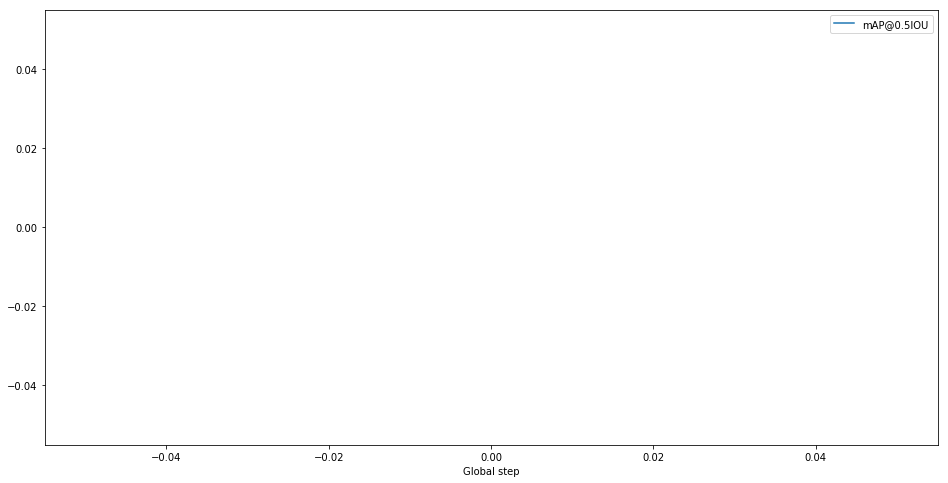

In [39]:
loss=[]
for r in findall("Loss/RPNLoss/localization_loss = {:f}", data):
    loss.append(r[0])
mAP=[]
for r in findall("/mAP@0.5IOU = {:f}", data):
    mAP.append(r[0])
step=[]
for r in findall("global_step = {:d}", data):
    step.append(r[0])
plt.figure(figsize=(16, 8))
plt.plot(step,mAP)
plt.xlabel('Global step')
plt.legend(['mAP@0.5IOU']);

Let's have a look at precision for each class:

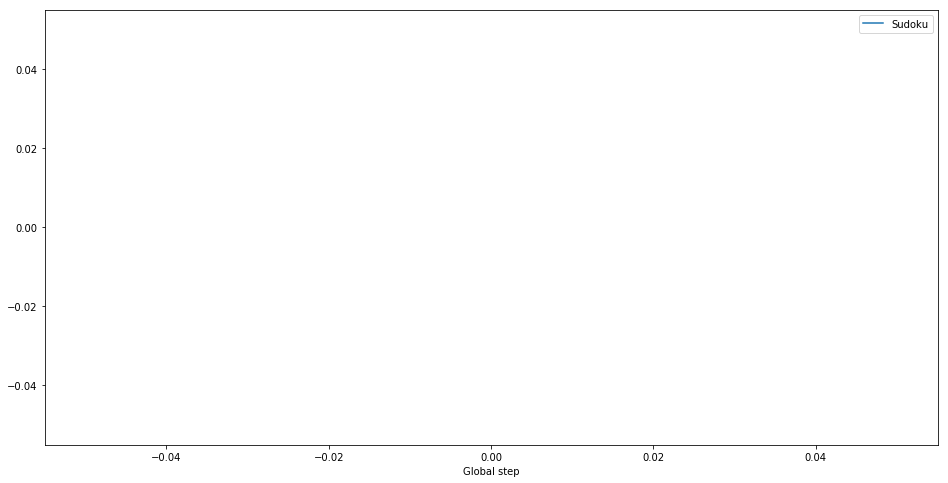

In [41]:
Sudoku=[]
for r in findall("AP@0.5IOU/Sudoku = {:f}", data):
    Sudoku.append(r[0])
# APColeoptera=[]
# for r in findall("AP@0.5IOU/Coleoptera = {:f}", data):
#     APColeoptera.append(r[0])
# APDiptera=[]
# for r in findall("AP@0.5IOU/Diptera = {:f}", data):
#     APDiptera.append(r[0])
# APHemiptera=[]
# for r in findall("AP@0.5IOU/Hemiptera = {:f}", data):
#     APHemiptera.append(r[0])
# APHymenoptera=[]
# for r in findall("AP@0.5IOU/Hymenoptera = {:f}", data):
#     APHymenoptera.append(r[0])
# APLepidoptera=[]
# for r in findall("AP@0.5IOU/Lepidoptera = {:f}", data):
#     APLepidoptera.append(r[0])
# APOdonata=[]
# for r in findall("AP@0.5IOU/Odonata = {:f}", data):
#     APOdonata.append(r[0])
plt.figure(figsize=(16, 8))
plt.plot(step,Sudoku)
# plt.plot(step,APColeoptera)
# plt.plot(step,APDiptera)
# plt.plot(step,APHemiptera)
# plt.plot(step,APHymenoptera)
# plt.plot(step,APLepidoptera)
# plt.plot(step,APOdonata)
plt.xlabel('Global step')
# plt.legend(['AP Araneae', 'AP Coleoptera', 'AP Diptera', 'AP Hemiptera', 'AP Hymenoptera', 'AP Lepidoptera', 'AP Odonata']);
plt.legend(['Sudoku']);

## Prediction (detections)
The easiest way to make predictions (or detections) with the trained model is to use the API supplied script `infer_detections.py`, which expects images in a TFRecord file. Note that this script is difficult on Windows machines. We will make predictions on the [ArTaxOr TestSet](https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-testset). The [starter kernel](https://www.kaggle.com/mistag/starter-arthropod-taxonomy-orders-testset) outputs a TFRecord file, so we can simply link to that. The detections are output in a separate TFRecord file, which we will process further down.

In [45]:
%%capture cap_out --no-stderr
!python object_detection/inference/infer_detections.py \
  --input_tfrecord_paths=/kaggle/working/prog_outputs/tf-records/test.record \
  --output_tfrecord_path=/kaggle/working/sudoku_detections.record \
  --inference_graph=/kaggle/working/trained/frozen_inference_graph.pb \
  --discard_image_pixels

In [51]:
!ls /kaggle/working/

__notebook_source__.ipynb  include	 readme.txt  trained
bin			   prog_outputs  train.log   trained_model.tar.gz


First, we'll import pickled annotation data from the [ArtAxOr TestSet Starter notebook](https://www.kaggle.com/mistag/starter-arthropod-taxonomy-orders-testset). Then we read in the TFRecord with the detections, and create a Pandas frame with the detected bounding boxes.

In [ ]:
# %%capture
# import pandas as pd
# import tensorflow as tf

# labels=pd.read_pickle('/kaggle/input/starter-arthropod-taxonomy-orders-testset/testset_labels.pkl')
# df=pd.read_pickle('/kaggle/input/starter-arthropod-taxonomy-orders-testset/testset_filelist.pkl')
# anno=pd.read_pickle('/kaggle/input/starter-arthropod-taxonomy-orders-testset/testset_objects.pkl')

In [44]:
pdf=pd.DataFrame(columns=['score', 'label_idx', 'left', 'top', 'right', 'bottom', 'by', 'filename'])
example = tf.train.Example()
for record in tf.compat.v1.io.tf_record_iterator('/kaggle/working/sudoku_detections.record'):
    example.ParseFromString(record)
    f = example.features.feature
    score = f['image/detection/score'].float_list.value
    score = [x for x in score if x >= 0.60]
    l = len(score)
    pdf=pdf.append({'score': score,
                    'label_idx': f['image/detection/label'].int64_list.value[:l],
                    'left': f['image/detection/bbox/xmin'].float_list.value[:l],
                    'top': f['image/detection/bbox/ymin'].float_list.value[:l],
                    'right': f['image/detection/bbox/xmax'].float_list.value[:l],
                    'bottom': f['image/detection/bbox/ymax'].float_list.value[:l],
                    'by': f['image/by'].bytes_list.value[0].decode(),
                    'filename': f['image/filename'].bytes_list.value[0].decode()}, ignore_index=True)

NotFoundError: /kaggle/working/sudoku_detections.tfrecord; No such file or directory

In [ ]:
# pdf.head()

Then we define a few helper functions for plotting the test images and bounding boxes.

In [ ]:
# !pip install --user python-resize-image -q

In [ ]:
# from PIL import Image, ImageFont, ImageDraw
# from resizeimage import resizeimage
# import numpy as np

# TSET_PATH = '/kaggle/input/arthropod-taxonomy-orders-object-detection-testset/ArTaxOr_TestSet/'

# #fontname = 'C:/Windows/fonts/micross.ttf' # Windows
# fontname = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf' # Linux
# font = ImageFont.truetype(fontname, 20) if os.path.isfile(fontname) else ImageFont.load_default()

# def resize_image(file, width, height, stretch=False):
#     with Image.open(file) as im:
#         img = im.resize((width, height)) if stretch else resizeimage.resize_contain(im, [width, height])
#     img=img.convert("RGB")    
#     return img

# #draw boundary box
# def bbox(img, xmin, ymin, xmax, ymax, color, width, label, score):
#     draw = ImageDraw.Draw(img)
#     xres, yres = img.size[0], img.size[1]
#     box = np.multiply([xmin, ymin, xmax, ymax], [xres, yres, xres, yres]).astype(int).tolist()
#     txt = " {}: {}%" if score >= 0. else " {}"
#     txt = txt.format(label, round(score, 1))
#     ts = draw.textsize(txt, font=font)
#     draw.rectangle(box, outline=color, width=width)
#     if len(label) > 0:
#         if box[1] >= ts[1]+3:
#             xsmin, ysmin = box[0], box[1]-ts[1]-3
#             xsmax, ysmax = box[0]+ts[0]+2, box[1]
#         else:
#             xsmin, ysmin = box[0], box[3]
#             xsmax, ysmax = box[0]+ts[0]+2, box[3]+ts[1]+1
#         draw.rectangle([xsmin, ysmin, xsmax, ysmax], fill=color)
#         draw.text((xsmin, ysmin), txt, font=font, fill='white')
    
# #prediction
# def plot_img_pred(img, xres, yres, axes, scores, xmin, ymin, xmax, ymax, classes, title, by=''):
#     wscale = min(1,xres/yres)
#     hscale = min(1,yres/xres)
#     for i in range(len(scores)):
#         if scores[i]> 0.5 and classes[i]>0:
#             label = labels.name.iloc[int(classes[i]-1)]
#             color=labels.color.iloc[int(classes[i]-1)]
#             width, height = xmax[i]-xmin[i], ymax[i]-ymin[i]
#             xcenter, ycenter = xmin[i] + width/2., ymin[i] + height/2.
#             sxmin = .5+(xcenter-.5)*wscale-.5*wscale*width
#             symin = .5+(ycenter-.5)*hscale-.5*hscale*height
#             sxmax = .5+(xcenter-.5)*wscale+.5*wscale*width
#             symax = .5+(ycenter-.5)*hscale+.5*hscale*height
#             bbox(img, sxmin, symin, sxmax, symax, color, 2, label, 100*scores[i])
#     plt.setp(axes, xticks=[], yticks=[])
#     axes.set_title(title) if by == '' else axes.set_title(title+'\n'+by)
#     plt.imshow(img)

# #ground truth
# def plot_img_gt(img, axes, boxes, stretch, title, by=''):
#     wscale = 1. if stretch else min(1,boxes.xres.iloc[0]/boxes.yres.iloc[0])
#     hscale = 1. if stretch else min(1,boxes.yres.iloc[0]/boxes.xres.iloc[0])
#     for i in range(len(boxes)):
#         label = boxes.label.iloc[i]
#         color=labels.color.iloc[boxes.label_idx.iloc[i]]
#         xmin = .5+(boxes.xcenter.iloc[i]-.5)*wscale-.5*wscale*boxes.width.iloc[i]
#         ymin = .5+(boxes.ycenter.iloc[i]-.5)*hscale-.5*hscale*boxes.height.iloc[i]
#         xmax = .5+(boxes.xcenter.iloc[i]-.5)*wscale+.5*wscale*boxes.width.iloc[i]
#         ymax = .5+(boxes.ycenter.iloc[i]-.5)*hscale+.5*hscale*boxes.height.iloc[i]
#         bbox(img, xmin, ymin, xmax, ymax, color, 2, label, -1)
#     plt.setp(axes, xticks=[], yticks=[])
#     axes.set_title(title) if by == '' else axes.set_title(title+'\n'+by)
#     plt.imshow(img)

# def pred_batch(idx):
#     if idx + 2 < len(pdf):
#         rows = 3
#     else:
#         rows = len(pdf) - idx
#     fig = plt.figure(figsize=(16,rows*8))
#     for i in range(rows):
#         img = resize_image(TSET_PATH+'positives/'+pdf.filename.iloc[i+idx], 512, 512, False)
#         by = pdf.by.iloc[i+idx]
#         axes = fig.add_subplot(rows, 2, 1+i*2)
#         boxes = anno[anno.id == df.id.iloc[i+idx]][['label', 'label_idx', 'xres', 'yres', 'xcenter', 'ycenter', 'width', 'height']]
#         plot_img_gt(img, axes, boxes, False, 'Ground truth', by)
#         img = resize_image(TSET_PATH+'positives/'+pdf.filename.iloc[i+idx], 512, 512, False)
#         axes = fig.add_subplot(rows, 2, 2+i*2)
#         plot_img_pred(img, boxes.xres.iloc[0], boxes.yres.iloc[0], axes, pdf.score[i+idx], pdf.left[i+idx], pdf.top[i+idx], 
#                       pdf.right[i+idx], pdf.bottom[i+idx],
#                       pdf.label_idx[i+idx], 'Detections', '')

Finally we can show some images, with ground truth to the left and detections to the right. Some detections are overlapping, and additional non-max suppression seems to be needed here.

In [ ]:
# pred_batch(0)

In [ ]:
# pred_batch(3)

In [ ]:
# pred_batch(6)

In [ ]:
# pred_batch(9)

In [ ]:
# pred_batch(12)

In [ ]:
# pred_batch(15)

In [ ]:
# pred_batch(18)

## Summary
Any object detection framework that has all files located in a directory called `research` should ring a few alarm bells when it comes to expectations of a slick user experience. However, we have seen that a few tweaks are all that is needed to get going with the TensorFlow Object Detection API. What about other options for object detection? PyTorch Detectron2 is the only other framework that has a pretrained model zoo, but currently it does not run on Kaggle (and no Windows support). TensorFlow Hub has several pre-trained models, and otherwise one would have to engage in detail implementation of models like YOLO etc. What we really need is to get object detection from research level and into mainstream.